This notebook answers a few basics questions about the COSMOS field data-- how many objects and candidates were detected, how objects are distributed among candidates, and how those distributions change when an R/B cutoff is applied.

In [1]:
# Login and access to database
import psycopg2
import psycopg2.extras
import getpass

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Math
import numpy as np
import pandas as pd

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


In [3]:
font = {'size'   : 16}

mpl.rc('font', **font)

In [4]:
def rm_dupes( arr, ecols=None ):
    """
    Removes duplicate rows from a numpy array. Has functionality to exclude some column(s) from the duplicate-finding process.
    For the purposes of these notebooks, that should be the index of the object ID column, if your array includes it, and left blank
    if not. For best results, make sure your array includes candidate id, R/B score, and something to tie it to a specific 
    exposure (fnm or eid)
    
    Takes:
    arr : the original array with some duplicate rows
    ecols : index/indices of excluded columns. NOTE: no matter what this index is, it will be the first column of res
    
    Returns:
    res : the original array with the duplicate rows removed
    """
    if ecols == None:
        dupes = arr
    else:
        dupes = np.delete(arr, ecols, axis=0)
    dupes = np.array( [" ".join(i) for i in dupes.transpose()] )
    unique, ind = np.unique( dupes, return_index=True )
    uarr = np.array( [ i.split(" ") for i in unique ] ).transpose()
    if ecols == None:
        res = uarr
    else:
        res = np.append( [arr[ecols][ind]], uarr, axis=0 )
    print( "%s duplicates removed" % ( len( arr[0] ) - len( res[0] ) ) )
    return res

#### How many standard images are in the COSMOS field?

In [5]:
query = ( 'SELECT e.filename, e.filter FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

expnumquery = np.array(cursor.fetchall()).transpose()

In [6]:
# truncate filenames to match lookup table format
fnms = [ expnumquery[0][i][:21] for i in range( len( expnumquery[0] ) ) ]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [7]:
filters = np.array(expnumquery[1])

# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
len(grimsk)

1043

#### How many objects total in the COSMOS field from standard images? (dupes removed)

In [13]:
query = ( 'SELECT o.id, e.filename, e.filter, o.rb, o.candidate_id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

objnum = np.array(cursor.fetchall()).transpose()

In [15]:
objnum = rm_dupes(objnum, 0)

objnum = pd.DataFrame(objnum.transpose(), columns=["ObjID", "Fnm", "Filter", "R/B", "CID"])

0 duplicates removed


In [16]:
# Grab lookup table for exposure times
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7]

# truncate filenames to match lookup table format
fnms = [objnum["Fnm"][i][:21] for i in range(len(objnum["Fnm"]))]

In [17]:
# find the exposure time for each object
exptime = [exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))]
objnum["Exptime"] = np.array(exptime).astype(float)

In [18]:
# Eliminate objects from non-standard images
gmsk = np.where((objnum["Filter"]=="g") & (objnum["Exptime"]>50))[0]
rmsk = np.where((objnum["Filter"]=="r") & (objnum["Exptime"]>20))[0]
imsk = np.where((objnum["Filter"]=="i") & (objnum["Exptime"]>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

In [19]:
# length of resulting mask is the total number of unique objects from science images
print("There are %s total objects from standard images in the COSMOS field data" % (len(grimsk)))
print("%s g-band objects" % (len(gmsk)))
print("%s r-band objects" % (len(rmsk)))
print("%s i-band objects" % (len(imsk)))

There are 1640243 total objects from standard images in the COSMOS field data
440773 g-band objects
819845 r-band objects
379625 i-band objects


#### How many good (R/B>0.6) objects total in the COSMOS field?

In [20]:
query = ( 'SELECT o.id, e.filename, e.filter, o.rb, o.candidate_id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000')
cursor.execute( query )

objnumg = np.array(cursor.fetchall()).transpose()

In [22]:
objnumg = rm_dupes(objnumg, 0)

objnumg = pd.DataFrame(objnumg.transpose(), columns=["ObjID", "Fnm", "Filter", "R/B", "CID"])

2002 duplicates removed


In [23]:
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)
fnms = [objnumg["Fnm"][i][:21] for i in range(len(objnumg["Fnm"]))] # truncate filenames to match lookup table format

In [24]:
# find the exposure time for each object
objnumg["Exptime"] = [exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))]

In [25]:
# Eliminate objects from non-standard images
gmsk = np.where((objnumg["Filter"]=="g") & (objnumg["Exptime"]>50))[0]
rmsk = np.where((objnumg["Filter"]=="r") & (objnumg["Exptime"]>20))[0]
imsk = np.where((objnumg["Filter"]=="i") & (objnumg["Exptime"]>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

In [26]:
print("There are %s total good (R/B > 0.6) objects from standard images in the COSMOS field data" % (len(grimsk)))
print("%s g-band objects" % (len(gmsk)))
print("%s r-band objects" % (len(rmsk)))
print("%s i-band objects" % (len(imsk)))

There are 159022 total good (R/B > 0.6) objects from standard images in the COSMOS field data
55468 g-band objects
61771 r-band objects
41783 i-band objects


#### How many candidates total in the COSMOS field?

In [27]:
# Not sure how I would go about eliminating candidates with detections only in non-standard images, but I imagine that fraction is negligible?
query = ( 'SELECT COUNT(*) FROM candidates c '
         'WHERE q3c_radial_query(c.ra,c.dec,150,2.2,3) ' 
         'LIMIT 10000000')
cursor.execute( query )

candnum = cursor.fetchall()[0][0]
print( candnum )

298779


#### How are the objects distributed among candidates (COSMOS, ignoring RB scores)?

In [28]:
### Returns objects.candidate_id for every object

query = ( 'SELECT candidate_id FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

cndobj_a = np.array( cursor.fetchall() ).transpose()
cndobj_a

array([['DC21e', 'DC21c', 'DC21f', ..., 'DC21mmu', 'DC21ttw', 'DC21dahl']],
      dtype='<U9')

In [29]:
# Finding out how many objects have a given candidate id
candidate_a, frequencies_a = np.unique( cndobj_a[0], return_counts=True )

THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~700
It also includes every object, regardless of rb score


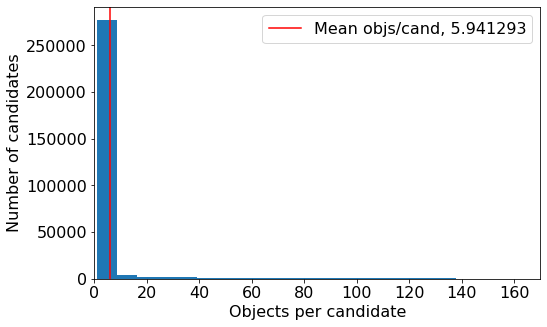

In [30]:
# Plotting it up
plt.figure( figsize=(8,5) )
plt.hist( frequencies_a, bins=100 )
plt.xlim( 0, 170 )
plt.xlabel( "Objects per candidate" )
plt.ylabel( "Number of candidates" )
plt.axvline( np.mean( frequencies_a ), label="Mean objs/cand, %f" % (np.mean(frequencies_a)), color='r' )
plt.legend()
print( "THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~700" )
print( "It also includes every object, regardless of rb score" )

#### Same analysis, but for only "good" object detections (COSMOS, R/B>0.6)

In [31]:
query = ( 'SELECT candidate_id, e.filename, e.filter, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE rb > 0.6 '
         'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'LIMIT 10000000')
cursor.execute( query )

cndobj_g = np.array( cursor.fetchall() ).transpose()

In [32]:
cndobj_g = rm_dupes(cndobj_g)

2002 duplicates removed


In [33]:
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)
fnms = [cndobj_g[1][i][:21] for i in range(len(cndobj_g[1]))] # truncate filenames to match lookup table format

In [34]:
# find the exposure time for each object
exptime = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))]).astype(float)

In [35]:
filters = cndobj_g[2]
# Eliminate objects from non-standard images
gmsk = np.where( (filters=="g") & (exptime>50) )[0]
rmsk = np.where( (filters=="r") & (exptime>20) )[0]
imsk = np.where( (filters=="i") & (exptime>20) )[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

In [36]:
# Finding out how many objects have a given candidate id
candidate_g, freq_g = np.unique( cndobj_g[0][gmsk], return_counts=True )
candidate_r, freq_r = np.unique( cndobj_g[0][rmsk], return_counts=True )
candidate_i, freq_i = np.unique( cndobj_g[0][imsk], return_counts=True )

THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~350
It includes only objects with rb scores above 0.6


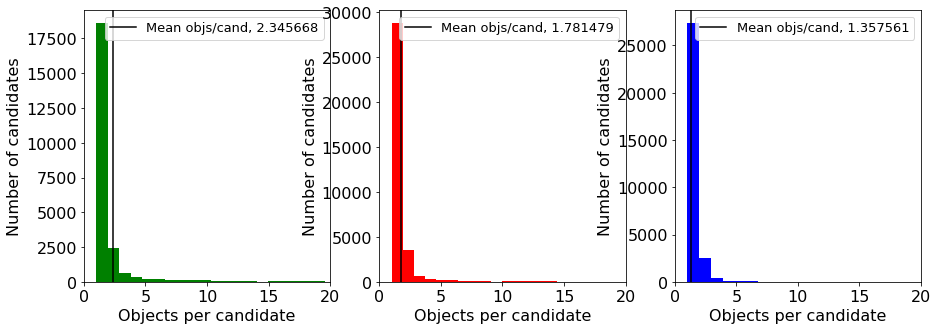

In [39]:
# Plotting it up
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
# plt.figure( figsize=(8,5) )
ax[0].hist( freq_g, bins=200, color = "g" )
ax[1].hist( freq_r, bins=200, color = "r" )
ax[2].hist( freq_i, bins=200, color = "b" )
ax[0].axvline( np.mean( freq_g ), label="Mean objs/cand, %f" % ( np.mean(freq_g) ), color='black' )
ax[1].axvline( np.mean( freq_r ), label="Mean objs/cand, %f" % ( np.mean(freq_r) ), color='black' )
ax[2].axvline( np.mean( freq_i ), label="Mean objs/cand, %f" % ( np.mean(freq_i) ), color='black' )
for i in [0,1,2]:
    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].set_xlim( 0, 20 )
    ax[i].set_xlabel( "Objects per candidate" )
    ax[i].set_ylabel( "Number of candidates" )
    ax[i].legend(fontsize=13)
print( "THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~350" )
print( "It includes only objects with rb scores above 0.6" )

#### How are objects.magnitude values correlated with objects.magerr values?

In [61]:
query = ( 'SELECT o.mag, o.magerr, e.filename, e.filter, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON s.id = o.subtraction_id '
         'JOIN exposures e ON e.id = s.exposure_id '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000')
cursor.execute( query )

magverr = np.array(cursor.fetchall()).transpose()

In [62]:
magverr = rm_dupes(magverr)

2002 duplicates removed


In [63]:
### Limiting to standard exposure times

# truncate filenames to match lookup table format
fnms = [ magverr[2][i][:21] for i in range( len( magverr[2] ) ) ]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

filters = np.array(magverr[3])

# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
# magverr = magverr.transpose()[grimsk].transpose()

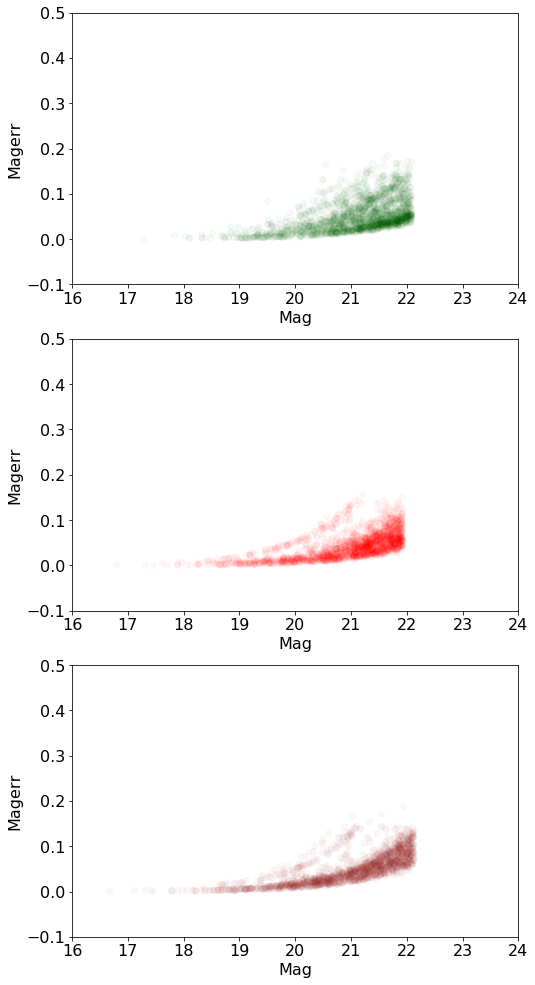

In [64]:
# Put in a random seed
np.random.seed(40)
# Select a sample of the objects to plot
rand = np.random.randint(0, high=.2*len(magverr[0]),size=2000)

fig, ax = plt.subplots( 3, figsize=(8,17), sharex=True )

ax[0].scatter(magverr[0].astype(float)[gmsk][rand], magverr[1].astype(float)[gmsk][rand], alpha = 0.03, color = "darkgreen")
ax[1].scatter(magverr[0].astype(float)[rmsk][rand], magverr[1].astype(float)[rmsk][rand], alpha = 0.03, color = "red")
ax[2].scatter(magverr[0].astype(float)[imsk][rand], magverr[1].astype(float)[imsk][rand], alpha = 0.03, color = "brown")
for i in ax:
    i.xaxis.set_tick_params(which='both', labelbottom=True)
    i.set_xlim(16,24)
    i.set_ylim(-0.1,0.5)
    i.set_xlabel("Mag")
    i.set_ylabel("Magerr")